# Combined Cycle Power Plant Regression

This is an analysis of the <a href="https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant">Combined Cycle Power Plant</a> dataset in the UCI archive.

In [1]:
import numpy as np
import pandas as pd
%pylab inline
pylab.style.use('ggplot')
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
pp_data = pd.read_csv('ccpp.csv')

In [3]:
pp_data.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


## Attribute Information

Features consist of hourly average ambient variables

    - Temperature (T) in the range 1.81°C and 37.11°C,
    - Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
    - Relative Humidity (RH) in the range 25.56% to 100.16%
    - Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg
    - Net hourly electrical energy output (EP) 420.26-495.76 MW

The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization. 

## Univariate Analysis

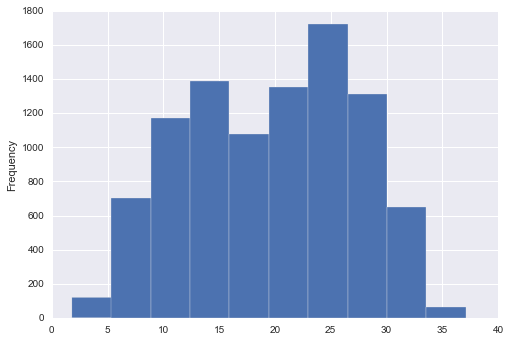

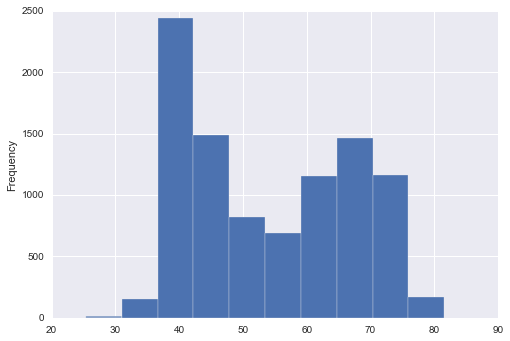

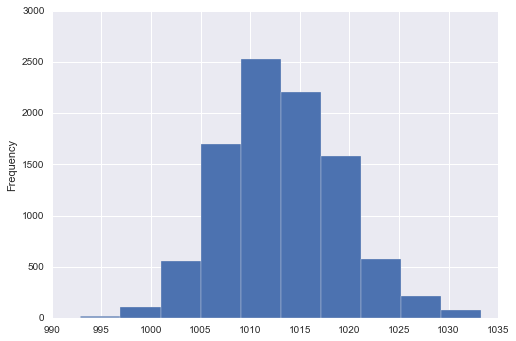

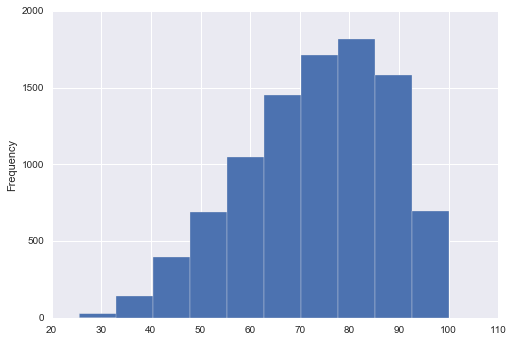

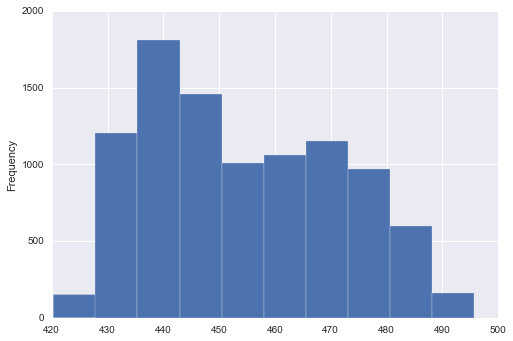

In [4]:
for c in pp_data.columns:
    _ = pylab.figure()
    pp_data.loc[:, c].plot(kind='hist')

## Correlation With the Target column

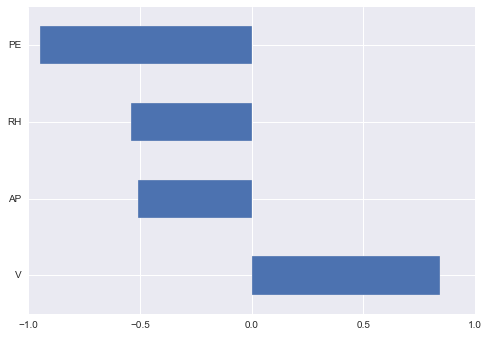

In [5]:
feature_data = pp_data.drop('AT', axis=1)
corrs = feature_data.corrwith(pp_data.loc[:, 'AT'])
corrs.sort_values(ascending=False).plot(kind='barh')

## Feature Correlations

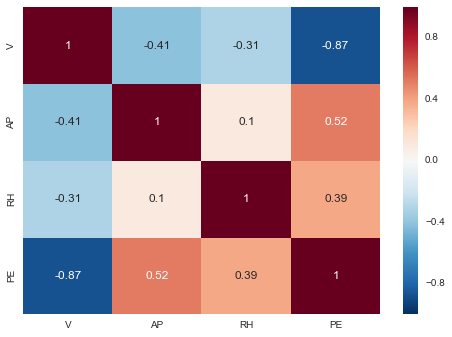

In [6]:
f_corrs = feature_data.corr()
sns.heatmap(f_corrs, annot=True)

## Bivariate Analysis

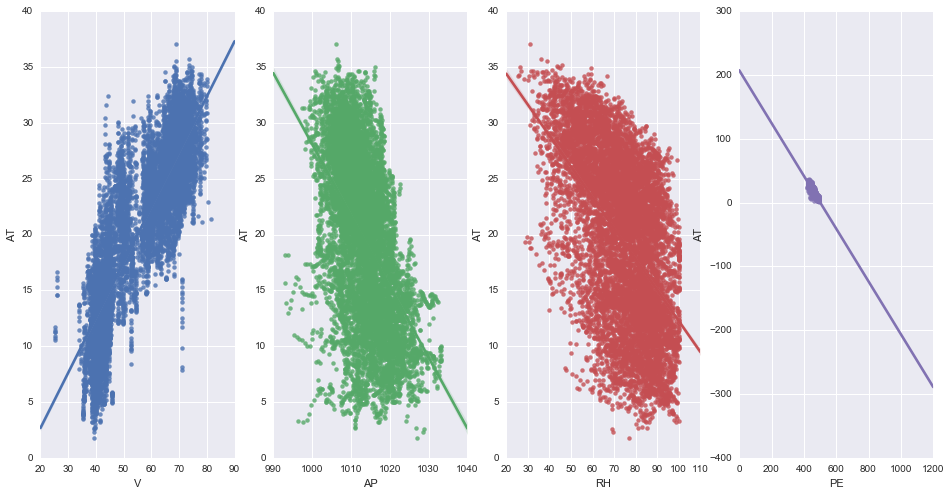

In [7]:
fig, axes = pylab.subplots(1, 4, figsize=(16, 8))

for i, c in enumerate(feature_data.columns):
    sns.regplot(x=c, y='AT', data=pp_data, ax=axes[i])

In [8]:
from sklearn.feature_selection import f_regression

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000230A5834A20>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000230A5EC4588>], dtype=object)

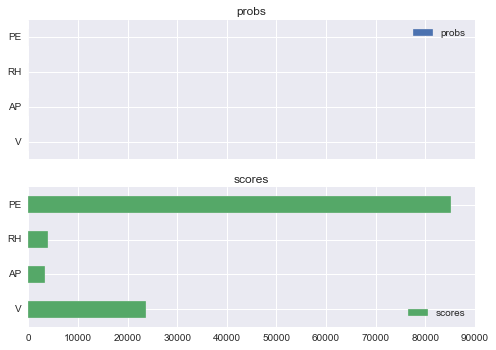

In [9]:
f_scores, f_probs = f_regression(feature_data, pp_data.loc[:, 'AT'])
f_imp_df = pd.DataFrame({'scores': f_scores, 'probs': f_probs}, index=feature_data.columns)
f_imp_df.plot(kind='barh', subplots=True)

## OLS Regression

In [10]:
import statsmodels.formula.api as sm

model = sm.ols(formula='AT ~ PE + RH + V', data=pp_data)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     AT   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 4.724e+04
Date:                Sat, 05 Aug 2017   Prob (F-statistic):               0.00
Time:                        23:00:43   Log-Likelihood:                -19584.
No. Observations:                9568   AIC:                         3.918e+04
Df Residuals:                    9564   BIC:                         3.921e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    178.4983      1.194    149.505      0.000     176.158     180.839
PE            -0.3397      0.002   -144.495      0.000      -0.344      -0.335
RH            -0.1058      0.001    -74.086      0.000      -0.109      -0.103
V              0.0602      0.003     19.677      0.000       0.054       0.066
==============================================================================
Omnibus:                      619.587   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2165.856
Skew:                          -0.264   Prob(JB):                         0.00
Kurtosis:                       5.270   Cond. No.                     2.89e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Cross-Validation

In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [20]:
n_splits = 10
fold = KFold(n_splits=n_splits, shuffle=True)

scores = []

for train_idx, test_idx in fold.split(pp_data):
    model = sm.ols(formula='AT ~ PE + RH + V', data=pp_data.loc[train_idx])
    result = model.fit()
    test_features = pp_data.loc[test_idx].drop('AT', axis=1)
    
    predictions = result.predict(test_features)
    actual = pp_data.loc[test_idx, 'AT']
    
    score = r2_score(actual, predictions)
    scores.append(score)
    
scores = pd.Series(scores)

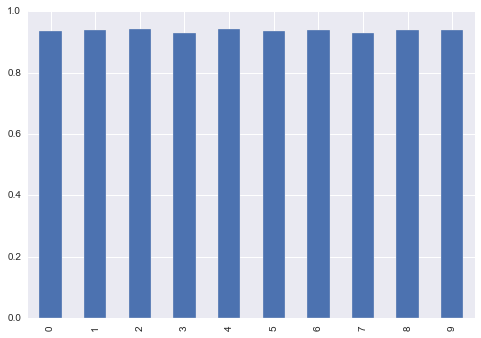

In [22]:
scores.plot(kind='bar')